<a href="https://colab.research.google.com/github/HernanDL/Noise-Cancellation-Using-GenAI/blob/main/TCN_Noise_Cancellation_with_Synthetic_Sounds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCN-based Urban Noise Prediction and Phase Cancellation

This Colab notebook implements a Temporal Convolutional Network (TCN) for predicting and canceling urban noise patterns. It generates synthetic urban noise, trains a TCN model on this data, and evaluates its performance on unseen uploaded WAV files.

## Table of Contents:
1. **Introduction**
2. **Importing Libraries**
3. **Define TCN Model Class**
4. **Synthetic Urban Noise Generation**
5. **Data Preparation**
6. **Building the TCN Model**
7. **Training the Model**
8. **Evaluating the Model**
9. **Saving and Loading the Model**
10. **Testing on Uploaded WAV File**
11. **Conclusion**

---

## 1. Introduction:
Urban noise includes sounds such as those from machinery, engines, and constant background hums. This noise spans a wide frequency range, typically from **20 Hz** (low hums) to **20,000 Hz** (high-pitched sounds). Traditional noise cancellation techniques may struggle with such a diverse spectrum, so we explore a TCN model that uses historical context to predict and invert these noises for better cancellation.

In this notebook, we'll:
- Generate synthetic urban-like noise patterns.
- Train a TCN model to predict and invert these noise patterns.
- Test the model on both synthetic data and real-world WAV files.
- Visualize the model's predictions and listen to the results.

## 2. Importing Libraries:
The necessary libraries for the TCN model, audio handling, and plotting are imported.


## 3. Define TCN Model Class:
The `WaveformPredictor` class manages the generation of synthetic noise, the training process, and predictions. It includes:
- Parameters for waveform generation, model architecture, and training.
- Methods to generate urban-like noise, prepare training data, build the TCN model, and plot results.


## 4. Synthetic Urban Noise Generation:
Synthetic noise is generated using a combination of random sine and cosine waves to simulate various urban noise patterns (e.g., engines, machinery). Each call to `generate_waveform` creates a unique pattern to encourage model generalization.

For urban noise types like machinery, engines, and constant background hums, the frequency ranges typically observed include:

1. **Low-Frequency Sounds (20 Hz - 250 Hz):**
   - Examples: HVAC systems, large industrial machines, engines (like cars, air conditioners), and traffic rumble.
   - These frequencies often carry a lot of energy and contribute to the "hum" or "rumble" background noise.

2. **Mid-Frequency Sounds (250 Hz - 2 kHz):**
   - Examples: Office equipment (like fans or printers), the sounds of machinery in operation, and engine noises from smaller vehicles.
   - These sounds can be more focused, including sounds of engines revving or general machinery whirring.

3. **High-Frequency Sounds (2 kHz - 10 kHz):**
   - Examples: Mechanical squeals, hissing sounds, and high-pitched components of machinery (like drills or electronic buzzes).
   - These frequencies are less about the “hum” and more about sharper sounds that can be irritating, like brake squeals or electrical buzzes.

4. **Very High Frequencies (10 kHz - 20 kHz):**
   - Examples: Some high-pitched electronic noises, whistling, or the faint high-end hiss from certain machinery.
   - While not as prominent as lower ranges, they can be relevant for detailed noise cancellation systems.

  ### Optimal Range for Noise Cancellation:
  Given the nature of urban noise, a balanced focus on the following range should give a good trade-off between speed, model complexity, and accuracy:

  - **20 Hz to 4 kHz**:
    - This range captures most of the engine sounds, hums, and machinery noises that are common in urban settings.
    - Frequencies above 4 kHz start to contribute less to the constant background hum and more to sharper, transient noises which are often less of a priority in noise-canceling scenarios focused on steady sounds.

  ### Considerations for Model Input Length (Sequence Length):
  - **Sequence Length**: To capture the relevant waveform features, a sequence length that covers 10-20 milliseconds is generally useful. For example:
    - At a **44.1 kHz sampling rate**, a **sequence length of 441 samples** covers 10 ms.
    - For more detailed analysis or smoother prediction, you might extend it to **882 samples** (covering 20 ms).

  This length provides a good balance, allowing the model to capture the oscillations of lower-frequency noise while maintaining manageable memory usage and speed during training. Using a broader input length (like several hundred milliseconds) would improve accuracy but significantly slow down the training and prediction speeds, which may not be ideal for real-time applications.


## 5. Data Preparation:
Data is prepared by generating multiple waveforms, segmenting them into sequences, and preparing input-output pairs for training. The output is the inverted phase of the noise, which helps the TCN model learn to predict signals that could cancel out the original noise.


## 6. Building the TCN Model:
The TCN model is constructed using convolutional layers with dilations for long-range dependencies. It uses the `Conv1D` layers with increasing dilation rates to capture complex temporal patterns.


## 7. Training the Model:
The model is trained on synthetic waveforms using a low learning rate for stability. Early stopping is used to prevent overfitting.


## 8. Evaluating the Model:
After training, the model is evaluated on new synthetic noise and the results are visualized. The following plots are generated:
- **Input Waveform**: The original test waveform.
- **Predicted Waveform**: The TCN model’s prediction.
- **Combined Waveform**: The sum of the input and predicted waveforms to evaluate phase cancellation.
- **Residual Noise (dB)**: Difference between input and predicted waveforms in decibels.


## 9. Saving and Loading the Model:
The trained model is saved for future use, allowing users to reload the model without retraining. This is helpful for testing the model with new inputs like WAV files.


## 10. Testing on Uploaded WAV File:
This section allows users to upload a WAV file, make predictions using the loaded TCN model, and visualize the results.


## 11. Conclusion:
The TCN model offers a robust approach for modeling and predicting complex noise patterns over time. By leveraging its ability to capture long-term dependencies, it can better predict the inverted phases needed for noise cancellation. While the training can be slow, especially for long sequences, it provides flexibility in handling diverse and non-stationary signals like urban noise.

### Initialization

In [11]:
# Uncomment for first run
#!pip install numpy matplotlib IPython tensorflow librosa scikit-learn

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import tensorflow as tf
import librosa
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from google.colab import files
from sklearn.metrics import mean_squared_error

class WaveformPredictorTCN:
    # Parameters for easy tuning
    num_training_waves = 500   # Number of waves to use for training (The higher the better for good generalization)
    duration = 1.0             # Duration in seconds (to capture longer noise patterns)
    sample_rate = 16000        # Samples per second (reduced for lower memory consumption)
    epochs = 1                 # Number of training epochs (Increase if required for better convergence)
    learning_rate = 0.001      # Learning rate for the optimizer (increase for faster learning)
    sequence_length = 50       # Number of previous samples to consider for prediction (reduced from 100 for memory efficiency)
    max_freq = 2000            # Maximum frequency for urban noise generation (focused on relevant range for average noises)
    batch_size = 32            # Batch size for training (reduced from 64 to cut memory usage)


    def __init__(self):
        self.model = self.build_model()
        self.device = self.set_device()

    def set_device(self):
        if tf.config.list_physical_devices('GPU'):
            print("Using GPU for training.")
            return 'GPU'
        else:
            print("Using CPU for training.")
            return 'CPU'

    def generate_waveform(self):
        t = np.linspace(0, self.duration, int(self.sample_rate * self.duration), endpoint=False)

        # Generate random urban noise-like signal by combining sine waves with varying amplitudes
        frequencies = np.random.uniform(20, self.max_freq, np.random.randint(3, 10))  # Random number of waves
        waveform = np.sum([np.random.uniform(0.2, 1.0) * np.sin(2 * np.pi * f * t) for f in frequencies], axis=0)

        return waveform / np.max(np.abs(waveform))  # Normalize to [-1, 1]

    def prepare_data(self):
        input_waveforms = np.array([self.generate_waveform() for _ in range(self.num_training_waves)])

        X, y = [], []
        for waveform in input_waveforms:
            for i in range(len(waveform) - self.sequence_length):
                X.append(waveform[i:i + self.sequence_length])
                y.append(-waveform[i + self.sequence_length])  # Predict the inverted phase

        X = np.array(X).reshape(-1, self.sequence_length, 1)
        y = np.array(y)
        return X, y

    def build_model(self):
        input_layer = layers.Input(shape=(self.sequence_length, 1))

        # First TCN block
        tcn = layers.Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu', dilation_rate=1)(input_layer)
        tcn = layers.BatchNormalization()(tcn)
        tcn = layers.Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu', dilation_rate=2)(tcn)
        tcn = layers.BatchNormalization()(tcn)

        # Second TCN block with increased dilation
        tcn = layers.Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu', dilation_rate=4)(tcn)
        tcn = layers.BatchNormalization()(tcn)

        # Flatten and dense layers for output
        flatten = layers.Flatten()(tcn)
        output_layer = layers.Dense(1)(flatten)

        model = models.Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mean_squared_error')
        return model

    def train(self):
        X, y = self.prepare_data()
        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        history = self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=1, callbacks=[early_stopping])
        return history

    def predict(self, test_waveform):
        X_test = []
        for i in range(len(test_waveform) - self.sequence_length):
            X_test.append(test_waveform[i:i + self.sequence_length])
        X_test = np.array(X_test).reshape(len(X_test), self.sequence_length, 1)
        predicted_waveform = self.model.predict(X_test)
        return predicted_waveform.flatten()  # Ensure it returns a 1D array

    def plot_results(self, test_waveform, predicted_waveform, combined_waveform):
        time_axis = np.linspace(0, self.duration, int(self.sample_rate * self.duration), endpoint=False)
        zoom_duration = 0.05  # 50 ms
        zoom_samples = int(self.sample_rate * zoom_duration)

        plt.figure(figsize=(15, 10))

        plt.subplot(5, 1, 1)
        plt.title('Input Waveform')
        plt.plot(time_axis[:zoom_samples], test_waveform[:zoom_samples], color='blue')
        plt.xlim(0, zoom_duration)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        plt.subplot(5, 1, 2)
        plt.title('Predicted Waveform')
        plt.plot(time_axis[self.sequence_length:self.sequence_length + zoom_samples], predicted_waveform[:zoom_samples], color='orange')
        plt.xlim(0, zoom_duration)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        plt.subplot(5, 1, 3)
        plt.title('Combined Waveform (Input + Predicted)')
        plt.plot(time_axis[self.sequence_length:self.sequence_length + zoom_samples], combined_waveform[:zoom_samples], color='green')
        plt.xlim(0, zoom_duration)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        plt.subplot(5, 1, 4)
        plt.title('Combined vs Input')
        plt.plot(time_axis[self.sequence_length:self.sequence_length + zoom_samples], combined_waveform[:zoom_samples], color='orange', label='Combined')
        plt.plot(time_axis[self.sequence_length:self.sequence_length + zoom_samples], test_waveform[self.sequence_length:self.sequence_length + zoom_samples], color='red', label='Input')
        plt.xlim(0, zoom_duration)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.legend()

        residuals = combined_waveform[:zoom_samples]
        residuals_db = 20 * np.log10(np.abs(residuals) + 1e-10)

        plt.subplot(5, 1, 5)
        plt.title('Residual Noise (dB)')
        plt.plot(time_axis[self.sequence_length:self.sequence_length + zoom_samples], residuals_db, color='red')
        plt.xlabel('Time (s)')
        plt.ylabel('Residual (dB)')
        plt.ylim(-100, 0)

        plt.tight_layout()
        plt.show()

    def save_model(self, path='tcn_noise_cancellation.keras'):
        self.model.save(path)
        print(f"Model saved to {path}")

    def load_model(self, path='tcn_noise_cancellation.keras'):
        self.model = models.load_model(path)
        print(f"Model loaded from {path}")

    def test_with_wav(self, wav_path):
        test_waveform, _ = librosa.load(wav_path, sr=self.sample_rate)
        # Normalize the test waveform to [-1, 1] if needed
        test_waveform = test_waveform / np.max(np.abs(test_waveform))

        # Make predictions with the model
        predicted_waveform = self.predict(test_waveform)

        # Calculate the combined waveform (input + predicted anti-noise)
        combined_waveform = test_waveform[self.sequence_length:] + predicted_waveform

        # Compare combined waveform to zero (silence target)
        silence_target = np.zeros_like(combined_waveform)
        validation_loss = mean_squared_error(silence_target, combined_waveform)

        print(f'Combined to Zero Validation Loss (MSE): {validation_loss}')

        # Plot results
        self.plot_results(test_waveform, predicted_waveform, combined_waveform)

        # Provide audio playback
        print("Test Input Waveform:")
        display(Audio(test_waveform, rate=self.sample_rate))
        print("Predicted Inverted Waveform:")
        display(Audio(predicted_waveform, rate=self.sample_rate))
        print("Combined Waveform:")
        display(Audio(combined_waveform, rate=self.sample_rate))

    def model_summary(self):
        self.model.summary()

# Usage
predictor_tcn = WaveformPredictorTCN()

# Show model summary
predictor_tcn.model_summary()


Using CPU for training.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 50, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 50, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 50, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 50, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 50, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 50, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 50, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           3,201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,929 (113.00 KB)

 Trainable params: 28,545 (111.50 KB)

 Non-trainable params: 384 (1.50 KB)

### Train and Plots

249219/249219 ━━━━━━━━━━━━━━━━━━━━ 3414s 14ms/step - loss: 0.0059
499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


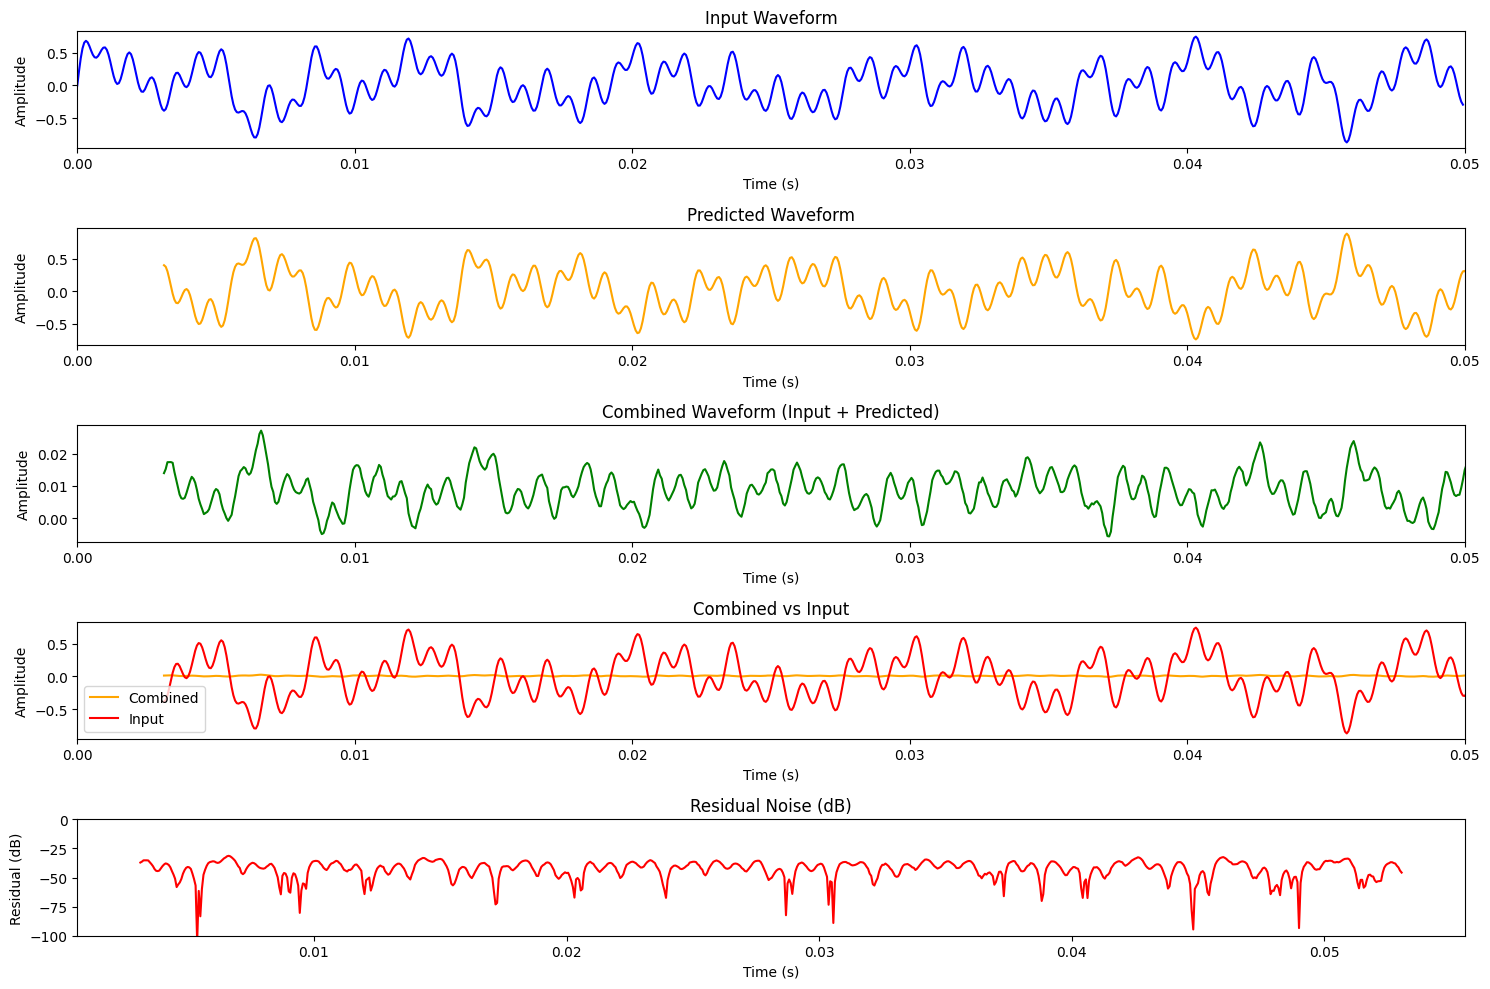

Test Input Waveform:


Predicted Inverted Waveform:


Combined Waveform:


In [2]:
history = predictor_tcn.train()

# Generate a new test waveform for prediction
test_waveform = predictor_tcn.generate_waveform()
predicted_waveform = predictor_tcn.predict(test_waveform)

# Calculate combined waveform
combined_waveform = test_waveform[predictor_tcn.sequence_length:] + predicted_waveform

# Plot results
predictor_tcn.plot_results(test_waveform, predicted_waveform, combined_waveform)

# Provide audio playback
print("Test Input Waveform:")
display(Audio(test_waveform, rate=predictor_tcn.sample_rate))
print("Predicted Inverted Waveform:")
display(Audio(predicted_waveform, rate=predictor_tcn.sample_rate))
print("Combined Waveform:")
display(Audio(combined_waveform, rate=predictor_tcn.sample_rate))

In noise cancellation tasks, especially when dealing with synthetic or real-world noises like urban noise or airplane cabin noise, the goal is to minimize the error between the predicted anti-noise and the actual noise, leading to effective noise reduction when combined.

Here’s a breakdown of what to aim for in terms of loss values:

### 1. **Target Loss Value:**
   - **Mean Squared Error (MSE)** is often used in such tasks, as it measures the average squared difference between the predicted and actual waveforms. For this scenario:
     - A **loss value below 0.001** indicates that the model is making highly precise predictions, with very small errors between the predicted anti-noise and the actual noise signal.
     - **Values between 0.001 and 0.01** may still represent good performance, especially if the noise has complex characteristics.
     - If the **loss is above 0.01**, the model’s performance might not be optimal, and further tuning or more training data may be necessary.
     - Aiming for **0.0001** to **0.0005** is ideal for achieving high-quality noise cancellation, especially in a controlled environment.

### 2. **Interpreting the Loss Values:**
   - **Lower loss** generally means that the model is better at matching the inverted waveform to cancel out the original noise.
   - However, **very low loss values** (e.g., below **0.0001**) might indicate overfitting to training data, meaning that the model might perform well during training but poorly with new, unseen noise patterns.

### 3. **Evaluation with Real-World Samples:**
   - It's crucial to evaluate the model not just based on training loss but also using **validation loss** with real-world noise samples, like the ones you plan to use in your predictions.
   - If the **validation loss** is close to the training loss (e.g., within **10-20%** difference), it indicates that the model generalizes well and will likely perform better with new sounds.

### 4. **Subjective Evaluation:**
   - Besides numerical loss, it's important to **listen to the output**:
     - The **combined waveform** should have a significantly reduced noise level when the anti-noise is applied.
     - It can be helpful to **plot the residual noise** in dB and observe the **reduction in amplitude** after applying the model’s output to the original noise.

### Summary:
   - Aim for an MSE loss between **0.0005** and **0.001** for effective noise cancellation.
   - Regularly check the **validation loss** to ensure the model is generalizing well.
   - Use **audio playback** and **visual plots** to assess the practical effectiveness of the model’s predictions.

By focusing on these loss values and subjective evaluation, you’ll be able to fine-tune your model for effective noise cancellation.

## 10. Testing on Uploaded WAV File:
This section allows users to upload a WAV file, make predictions using the loaded TCN model, and visualize the results.

In [3]:
# If you are primarily using the model for inference and don't need the optimizer state,
# you can save the model without the optimizer

predictor_tcn.model.save('tcn_noise_cancellation.keras', include_optimizer=False)


Model loaded from tcn_noise_cancellation.keras


Saving Input.wav to Input (1).wav
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step
Combined to Zero Validation Loss (MSE): 0.0002390660811215639


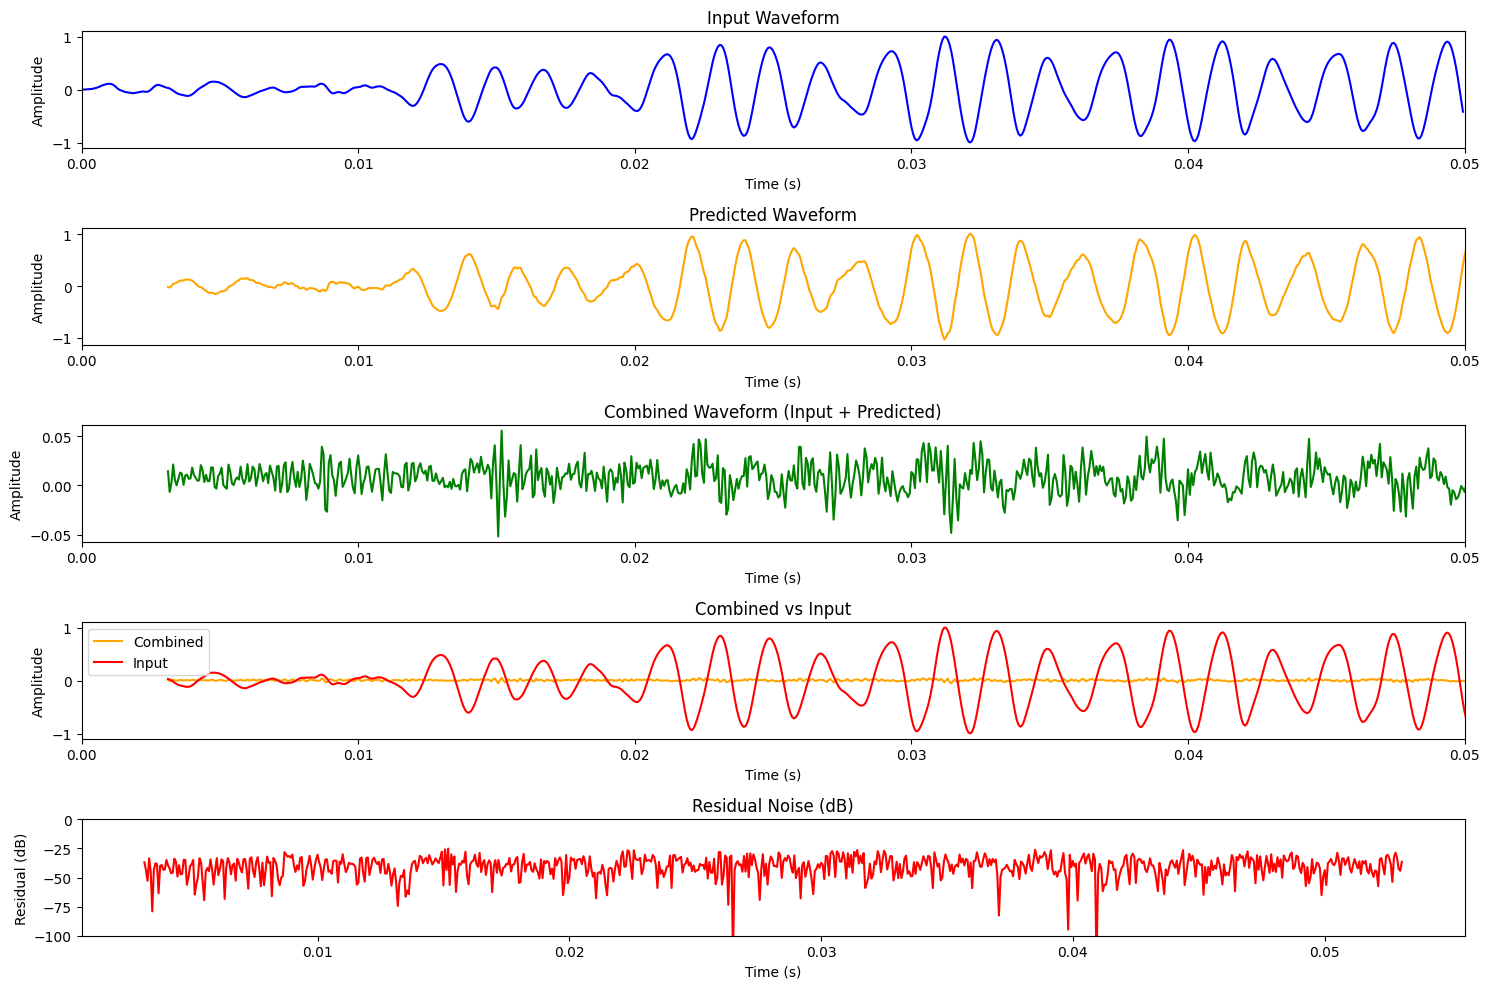

Test Input Waveform:


Predicted Inverted Waveform:


Combined Waveform:


In [10]:
# Test with a local WAV file
predictor_tcn.load_model('tcn_noise_cancellation.keras')

# Upload WAV file
uploaded = files.upload()
wav_filename = list(uploaded.keys())[0]

predictor_tcn.test_with_wav(wav_filename)

## Show Model Architecture

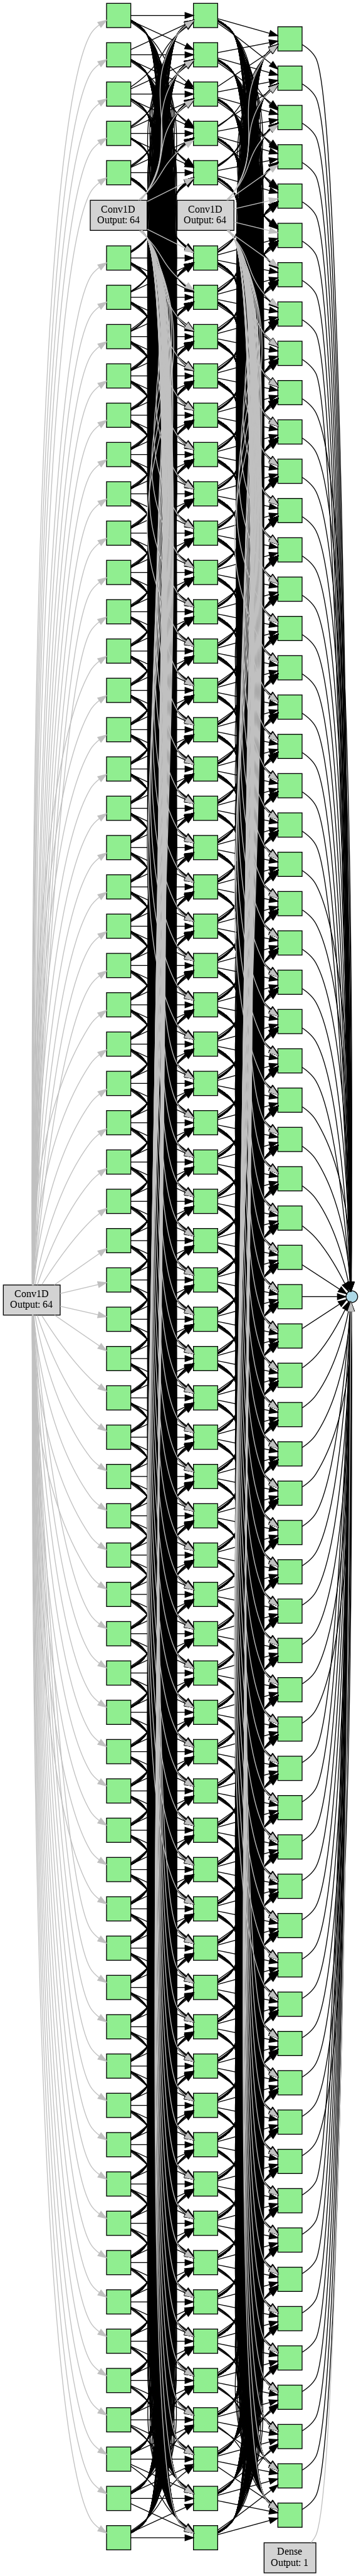

In [8]:
import pydot
from IPython.display import Image, display
from tensorflow.keras import models, layers

def visualize_neural_network_from_model(model):
    """
    Visualizes a neural network structure given a Keras model.

    Parameters:
    model (tf.keras.Model): A compiled Keras model.
    """
    # Extract the number of neurons per layer along with the layer type and output shape
    layers_info = []
    for layer in model.layers:
        # Extract relevant information based on layer type
        layer_type = layer.__class__.__name__
        if hasattr(layer, 'units'):  # Dense layers
            layers_info.append((layer.units, layer_type))
        elif hasattr(layer, 'filters'):  # Conv1D layers
            layers_info.append((layer.filters, layer_type))
        elif hasattr(layer, 'output_shape') and isinstance(layer.output_shape, tuple):
            # Use the output shape's last dimension for non-Dense, non-Conv layers
            layers_info.append((layer.output_shape[-1], layer_type))

    # Create a new directed graph with a left-to-right layout
    graph = pydot.Dot(graph_type='digraph', rankdir='LR')

    # Track the previous layer nodes for creating edges
    previous_layer_nodes = []

    # Loop through each layer and add nodes
    for i, (layer_size, layer_type) in enumerate(layers_info):
        current_layer_nodes = []
        for j in range(layer_size):
            # Create a node for each neuron/feature map in the layer
            node = pydot.Node(
                f'{layer_type} {i} Neuron {j}',
                label='',
                shape='circle' if 'Dense' in layer_type else 'box',
                style='filled',
                fillcolor='lightblue' if 'Dense' in layer_type else 'lightgreen',
                width='0.2' if 'Dense' in layer_type else '0.4',
                height='0.2' if 'Dense' in layer_type else '0.4'
            )
            graph.add_node(node)
            current_layer_nodes.append(node)

        # Create a label node for the layer type
        layer_label_node = pydot.Node(
            f'{layer_type} {i}',
            label=f'{layer_type}\nOutput: {layer_size}',
            shape='box',
            style='filled',
            fillcolor='lightgrey',
            fontsize='12',
            fontcolor='black'
        )
        graph.add_node(layer_label_node)

        # Connect the label node to all neurons in the current layer
        for node in current_layer_nodes:
            graph.add_edge(pydot.Edge(layer_label_node, node, color='gray'))

        # If this is not the first layer, add edges between previous and current layer nodes
        if previous_layer_nodes:
            for prev_node in previous_layer_nodes:
                for curr_node in current_layer_nodes:
                    edge = pydot.Edge(prev_node, curr_node)
                    graph.add_edge(edge)

        # Update the previous layer nodes
        previous_layer_nodes = current_layer_nodes

    # Save the graph to a PNG file
    graph.write_png('tcn_neural_network.png')

    # Display the image in the notebook
    display(Image('tcn_neural_network.png', retina=True))

visualize_neural_network_from_model(predictor_tcn.model)